In [1]:
#TUTORIAL: https://pyro.ai/examples/prodlda.html
import math
import torch
import torch.nn as nn #pip install torch torchvision torchaudio
import torch.nn.functional as F
import pyro #pip3 install pyro-ppl 
from pyro.infer import SVI, TraceMeanField_ELBO,  MCMC, NUTS 
import pyro.distributions as dist
from tqdm import trange
import os
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
import pyLDAvis.gensim #pip install pyLDAvis
import pyLDAvis.gensim_models


In [2]:
#Class to execute prodLDAModel
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)


class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

    def model(self, docs):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T

In [3]:
#Prepare dataset to be used in the model
source = './doc/cleaned.csv'
df = pd.read_csv(source)

# Split the text data into words based on spaces
tweets = df['lemmatized_text'].apply(lambda text: text.split())

# Create a CountVectorizer 
# max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
# min_df is used for removing terms that appear too infrequently, at least in 20 documents
vectorizer = CountVectorizer(max_df=0.5, min_df=20)

# Convert the tokenized text data into a document-term matrix
docs = torch.from_numpy(vectorizer.fit_transform([" ".join(tweet) for tweet in tweets]).toarray())

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names_out()
vocab['index'] = vocab.index


In [23]:
def get_word_cloud(model,vocab, n_topic, n_words):
    wordclouds = []
    for i in range(0,n_topic):
        b = model[i]
        sorted_, indices = torch.sort(b, descending=True)
        df = pd.DataFrame(indices[:n_words].numpy(), columns=['index'])
        words = pd.merge(df, vocab[['index', 'word']],
                        how='left', on='index')['word'].values.tolist()
        sizes = (sorted_[:n_words] * 1000).int().numpy().tolist()
        freqs = {words[i]: sizes[i] for i in range(len(words))}
        wc = WordCloud(width=850, height=850, random_state=17, colormap='viridis', background_color='white', max_font_size=160)
        wc = wc.generate_from_frequencies(freqs)
    
        wordclouds.append(wc)
    return wordclouds

def get_grid_word_cloud(title, wordclouds, n_row, n_col, save_path):
    fig, axes = plt.subplots(n_row, n_col, figsize=(20,12))
    fig.suptitle(title, fontsize=18,  fontweight='bold')
    for i, ax in enumerate(axes.flatten()):
        if i < len(wordclouds):  # Check if there are more plots to show
            ax.imshow(wordclouds[i])
            ax.set_title(f'Topic {i+1}')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            fig.delaxes(ax) 
    
    plt.tight_layout()
    plt.savefig(save_path+title, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    

In [24]:
def get_bar_chart(model, vocab, n_topic,n_row,n_col, n_words, title, save_path):
    #create colormap
    colors = plt.cm.tab10(range(n_words))
    
    fig, axes = plt.subplots(n_row, n_col, figsize=(20,12))
    fig.suptitle(title + f" - top {n_words} words for each topic with the terms frequency", fontsize=18,  fontweight='bold')
    
    for i, ax in enumerate(axes.flatten()):
        if i < n_topic:  # Check if there are more plots to show
            b = model[i] #get the topic
            sorted_, indices = torch.sort(b, descending=True)
            df = pd.DataFrame(indices[:n_words].numpy(), columns=['index'])
            words = pd.merge(df, vocab[['index', 'word']],how='left', on='index')['word'].values.tolist()
            sizes = (sorted_[:n_words] * 1000).int().numpy().tolist()  
            ax.barh(words, sizes, color=colors[i])
            ax.set_title(f'Topic {i+1}')
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_yticks(range(len(words)))
            ax.set_yticklabels(words, fontsize = 14, fontweight='bold')  # Make words bold
            ax.invert_yaxis()  # Invert the y-axis to show the most relevant word at the top
        else:
            fig.delaxes(ax) 
    
    plt.tight_layout()
    plt.savefig(save_path+title, bbox_inches='tight', pad_inches=0.2)
    plt.show()

/home/lucia/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/home/lucia/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/home/lucia/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap

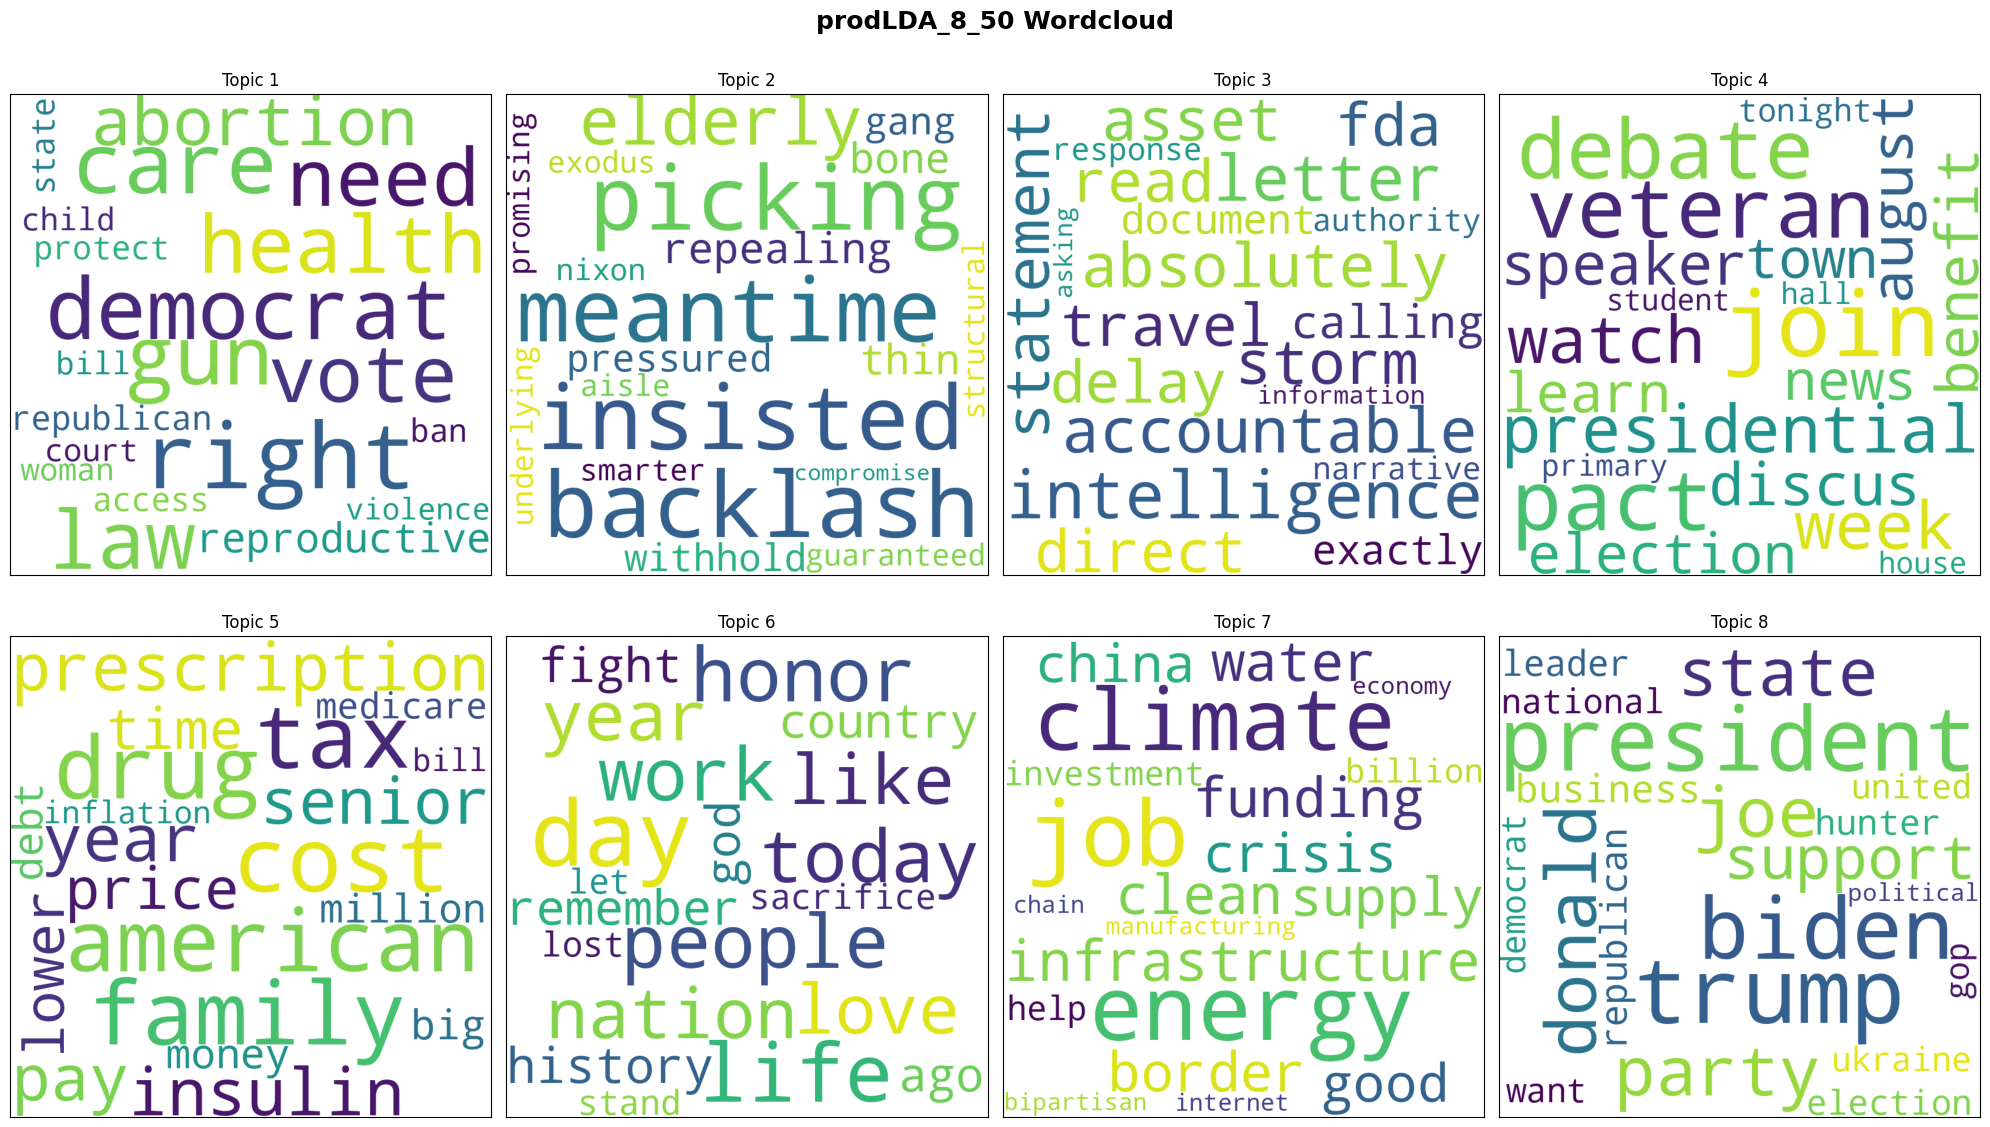

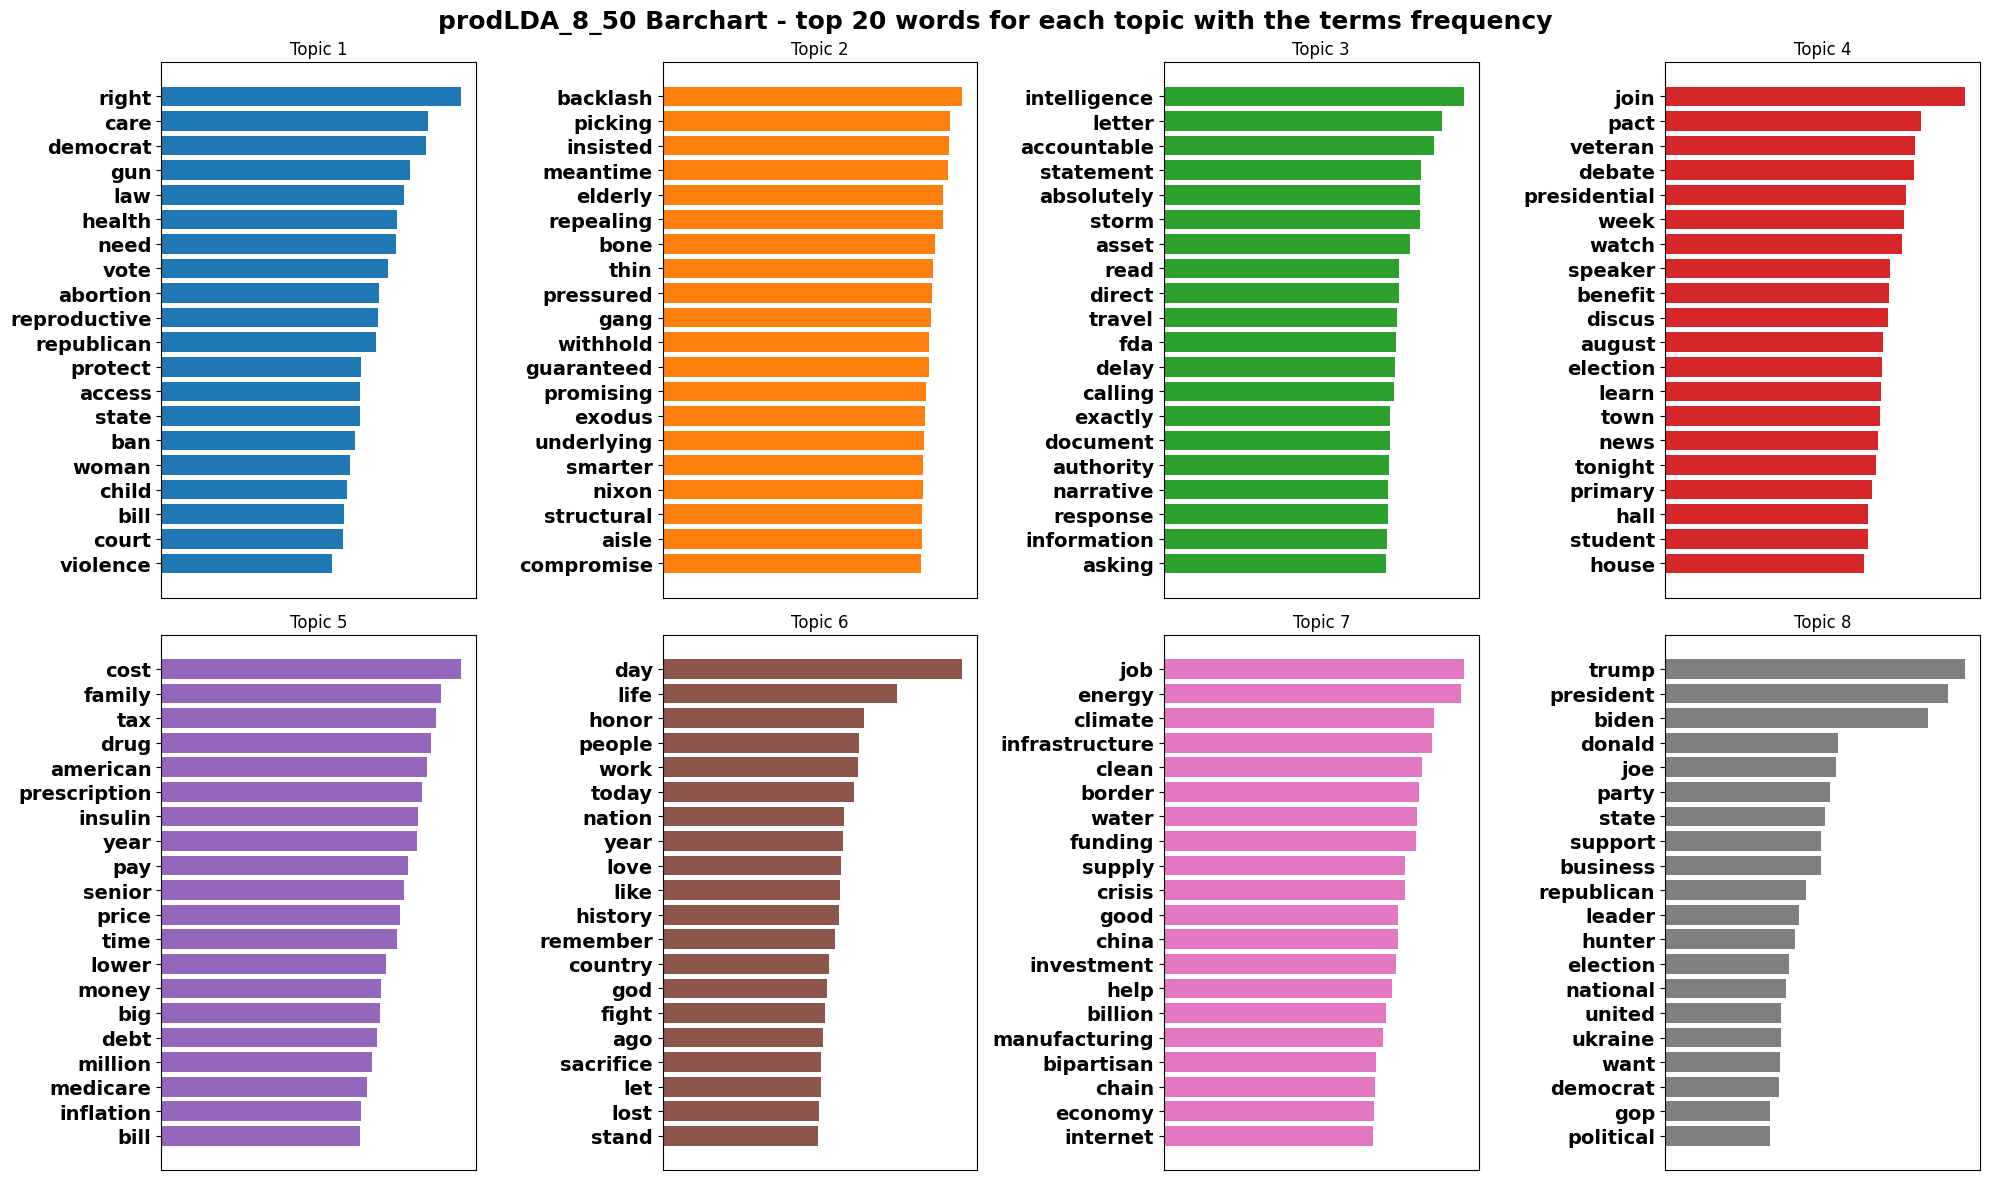

In [25]:
n_word = 20

num_topics = 8
num_epochs = 50
# Load the model's state_dict
path = f"models_prodLDA/prodLDA_{num_topics}_{num_epochs}.pth"
model = ProdLDA(vocab_size=docs.shape[1],num_topics=num_topics,  hidden=100,dropout=0.2)
model.load_state_dict(torch.load(path))

#Stampo wordclouds
beta = model.beta()
get_grid_word_cloud('prodLDA_8_50 Wordcloud', get_word_cloud(beta, vocab,num_topics, n_word),2,4,"wordclouds/")
get_bar_chart(beta, vocab, num_topics,2,4, n_word,"prodLDA_8_50 Barchart", "barchart/")